# Doppio pendolo

In questo esercizio si vogliono risolvere le equazioni del moto per il doppio pendolo tramite il metodo di Runge Kutta al quarto ordine, quindi disegnare un grafo dell'energia del sistema contro il tempo e visualizzare una animazione del moto del sistema.

## Introduzione

Il doppio pendolo è un sistema costituito da un pendolo nella cui estremità libera viene incernierato un secondo pendolo. Nella formulazione più semplice le aste sono rigide e prive di massa, che è concentrata nelle due masse puntiformi vincolate alle loro estremità. In quanto segue si supporrà inoltre, per semplicità, che le aste abbiano la stessa lunghezza $l$ e le masse inerziali lo stesso valore $m$.

La dinamica di questo sistema può essere semplicemente descritta in coordinate generalizzate nel formalismo lagrangiano, tuttavia non sono note soluzioni analitiche delle equazioni del moto. Inoltre queste soluzioni sono un noto esempio di comportamento _caotico_, ovvero di un sistema la cui dinamica è deterministica ma le cui traiettorie sono fortemente sensibili dalle condizioni iniziali.

Siano $v_1$ e $v_2$ le velocità delle due masse, $h_1$ e $h_2$ le loro quote rispetto alla cerniera del primo pendolo e $g$ l'accelerazione di gravità locale. Se si pone che il punto zero dell'energia potenziale della forza peso sia a $h_1 = h_2 = 0$ allora la lagrangiana del sistema si può scrivere come

\begin{equation}
\mathcal{L} = \frac{1}{2} m v_1^2 \frac{1}{2} m v_2^2 + m g h_1 + m g h_2
\end{equation}

Se ora si indicano con $\theta_1$ e $\theta_2$ gli angoli formati rispettivamente dalla prima e dalla seconda asta con la verticale, allora la lagrangiana si può riscrivere in queste nuove coordinate come

\begin{equation}
\mathcal{L} = m l^2 \left( \dot{\theta}_1^2 + \frac{1}{2} \dot{\theta}_2^2 + \dot{\theta}_1 \dot{\theta}_2 \cos(\theta_1 - \theta_2) \right) + m g l \left( 2 \cos(\theta_1) + \cos(\theta_2) \right)
\end{equation}

Dal momento che si vogliono integrare numericamente le equazioni del moto (equazioni di Eulero-Lagrange), dapprima si riportano queste ultime in forma canonica e successivamente si riconducono ad un sistema di equazioni del primo ordine introducendo le variabili ausiliarie $\omega_1 = \dot{\theta}_1$ e $\omega_2 = \dot{\theta_2}$. Le equazioni differenziali per $\omega_1$ e $\omega_2$ che si ottengono in questo modo sono

\begin{align}
\dot{\omega_1} = & \frac{\omega_1^2 \sin(2 \theta_1 - 2 \theta_2 ) + 2 \omega_2^2 \sin(\theta_1 - \theta_2) + \frac{g}{l} \left( \sin( \theta_1 - 2 \theta_2 ) + 3 \sin( \theta_1 ) \right)}{3 - \cos(2 \theta_1 - 2 \theta_2 )} \\
\dot{\omega_2} = & \frac{ 4 \omega_1^2 \sin(\theta_1 - \theta_2 ) + \omega_2^2 \sin(2 \theta_1 - 2 \theta_2) + 2 \frac{g}{l} \left( \sin( 2 \theta_1 - \theta_2 ) - \sin( \theta_2 ) \right)}{3 - \cos(2 \theta_1 - 2 \theta_2 )}
\end{align}

Queste equazioni vengono integrate numericamente utilizzando il metodo di Runge Kutta del 4 ordine adattivo.

## Operazioni preliminari

Si importano prelimiramente i moduli necessari. Si osserva che da un punto di vista delle prestazioni è bene utilizzare su scalari le funzioni fornite dal modulo `math` piuttosto degli equivalenti vettoriali del modulo `numpy` (sopratutto nei casi come quello in considerazione in cui queste funzioni vengono valutate un numero grande di volte).

In [1]:
# importing modules
import numpy as np
from math import sin, cos, sqrt
from scipy.constants import g
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# display configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
from base64 import b64encode
from IPython.display import HTML

def video(filename):
    video_tag = '''<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>'''
    raw = open(filename,'rb').read()
    encoded = b64encode(raw)
    encoded_ascii = video_tag.format(encoded.decode('ascii'))
    return HTML(data=encoded_ascii)

Inoltre si fissano i valori dei parametri, le unità sono quelle del sistema internazionale.

In [3]:
l = 0.4 # arm length, 40cm
m = 1.0 # bob mass, 1kg

## Metodo di Runge Kutta del quarto ordine adattivo

Viene implementato il metodo di Runge Kutta al quarto ordine adattivo come descritto in \cite{newman2012computational}.

Questo metodo consiste nello stimare il punto successivo della traiettoria che si sta integrando tramite il metodo di Runge Kutta due volte consecutive, la seconda volta con passo dimezzato (cosa che richiede una terza valutazione nel punto intermedio). Da queste due valutazioni è possibile stimare l'errore (al quinto ordine) e, in base a quest'ultimo, modificare il passo per ottenere il livello di precisione desiderato.

In generale questo metodo richiede maggiore lavoro per ciclo, sia da un punto di vista algoritmico, ovvero la valutazione di almeno tre iterazioni del metodo di Runge Kutta per ogni punto, che dal punto di vista dell'implementazione specifica, infatti non essendo noto a priori il numero di punti in cui verrà suddiviso l'intervallo di integrazione non è possibile preallocare un vettore e si deve utilizzare una lista, la cui manipolazione richiede maggiori risorse di calcolo (sarebbe possibile allocare un vettore di una arbitraria dimensione massima consentita, ma questo comporterebbe comunque spreco di memoria).

Nonostante questo maggior carico di lavoro, questo metodo fornisce una stima dell'errore ed inoltre, in generale, i gradi di libertà aggiuntivi, introdotti usando un passo di integrazione variabile, compensano questo carico permettendo di raggiungere il livello di precisione desiderato valutando un numero minor numero di punti (dunque con minor tempo di calcolo).

Si osserva che per implementare il metodo adattivo descritto è necessario un valore di partenza per il passo, che in linea di principio può essere del tutto arbitrario venendo corretto nelle iterazioni successive. Tuttavia, se $d$ è la precisione richiesta sull'intervallo di integrazione, allora l'errore sul singolo passo sarà $d h$, d'altro canto per il metodo considerato gli errori sono del quinto ordine nel passo di integrazione, ovvero $c h^5$, pertanto se $c$ è dell'ordine dell'unità una scelta iniziale plausibile del passo di integrazione è $h = \sqrt[4]{d}$.

Un'altra osservazione è che, rispetto a quanto descritto in \cite{newman2012computational}, invece della quantità (definita nel caso di una equazione del primo ordine in una variabile indipendente)

\begin{equation}
\rho^{\frac{1}{4}} = \left(\frac{30 h d}{\vert x_3 - x_2 \vert} \right)^{\frac{1}{4}}
\end{equation}

si considera il suo inverso $s = \left( \dfrac{1}{\rho} \right)^{\frac{1}{4}}$ (a cui è associata nel codice la variabile `s`). 

Infatti mentre la differenza $\vert x_3 - x_2 \vert$ può essere molto piccola e pertanto è necessario effettuare un controllo per evitare una divisione per zero, nel caso di $s$ il denominatore è sempre non nullo (se si esclude che $d$ o $h$ possano essere nulli) e pertanto si aggira questo problema. 

Si osserva che nel caso appena descritto $\rho$ diventa molto grande, tuttavia questo non implica che si possa ottenere il livello di precisione desiderato con un passo $h' = h \rho^{\frac{1}{4}}$ grande: infatti in questo caso la formula per la stima dell'errore fallisce e sarebbe necessario considerare i contributi di ordine superiore. Per questa ragione si pone un limite inferiore sul valore di $s$ pari a 0.5, in modo che il passo nella valutazione di due punti adiacenti può alpiù raddoppiare (in base a $h' = s^{-1} h$).

Nel caso di equazioni di ordine superiore o a più di una variabile indipendente si pone il problema di generalizzare la quanità $\vert x_3 - x_2 \vert$. Nella implementazione si è adottata la norma

\begin{equation}
\Vert x \Vert = \min_{i = 1 \dots n}\{x_i\}
\end{equation}

in modo che l'errore per ciascuna variabile sia al disotto del livello di precisione richiesto.

Per ultimo si ricorda che grazie alla _estrapolazione locale_ si ottiene un risultato accurato al quinto ordine (senza tuttavia avere una stima dell'errore per quest'ultimo).

In [4]:
def f(x,t):
    
    th1, w1, th2, w2 = x
    
    c = 1/(3 - cos(2*(th1 - th2)))
    
    th1_ = w1
    w1_ = -c*(w1*w1*sin(2*(th1-th2)) + 2*w2*w2*sin(th1-th2) + (g/l)*(sin(th1-2*th2) + 3*sin(th1)))
    th2_ = w2
    w2_ = c*(4*w1*w1*sin(th1-th2) + w2*w2*sin(2*(th1-th2)) + 2*(g/l)*(sin(2*th1-th2) - sin(th2)))
    
    return np.array([th1_,w1_,th2_,w2_])

def energy(x):
    
    th1, w1, th2, w2 = x.T
    
    V = -m*g*l*(2*np.cos(th1) + np.cos(th2))
    T = m*l*l*(w1*w1 + 0.5*w2*w2 + w1*w2*np.cos(th1 - th2))
    
    return V+T

def nextPoint(x,t,h):
    
    k1 = h*f(x,t)
    k2 = h*f(x+0.5*k1,t+0.5*h)
    k3 = h*f(x+0.5*k2,t+0.5*h)
    k4 = h*f(x+k3,t+h)
    
    return x + (k1+2*k2+2*k3+k4)/6.0

def adaptiveRungeKutta4(f0,a,b,d):
    
    # first guess
    h = d**0.25
    
    # initialization
    x = f0
    xx = [x]
    t = a
    tt = [t]
    
    while t+2*h < b:
        
        x1 = nextPoint(x,t,h)
        x2 = nextPoint(x1,t+h,h)
        x3 = nextPoint(x,t,2*h)
        
        ss = (np.abs(x3-x2)/(30.0*h*d))**0.25
        s = max(min(ss),0.5)

        while s > 1:
            h /= 2
            
            x1 = nextPoint(x,t,h)
            x2 = nextPoint(x1,t+h,h)
            x3 = nextPoint(x,t,2*h)
            
            ss = (np.abs(x3-x2)/(30.0*h*d))**0.25
            s = max(min(ss),0.5)
        
        h /= s
        x = x2 + (x2-x3)/15.0
        t += 2*h
        xx += [x]
        tt += [t]
        
    xx += [nextPoint(x,t,b-t)]
    tt += [b]
            
    return np.array(tt), np.array(xx)

## Energia del sistema

Tramite le funzioni definite è possibile integrare le equazioni del moto e visualizzare l'energia del sistema in poche righe di codice. 

Si richiede a questo punto che l'energia non vari nell'intervallo di integrazione, a causa del livello di accuratezza del calcolo, oltre $10^{-5} J$ dal valore iniziale (che per la scelta dei valori al contorno é nullo). Il valore di accuratezza che produce una escursione dell'energia entro la soglia richiesta può essere trovato per tentativi e in particolare si verifica che per `d` pari a $10^{-7}$ si ottiene il risultato desiderato.

Delta E :  7.46703324089e-06


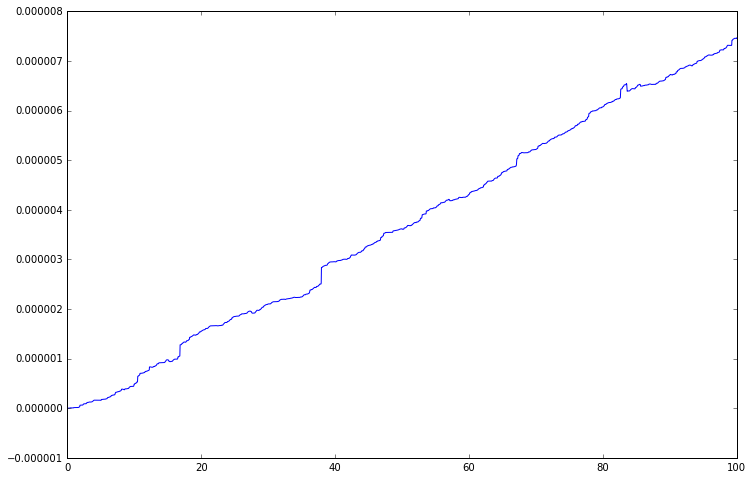

In [5]:
f0 = np.radians([90,0,90,0])
a = 0
b = 100
d = 1e-7

t, x = adaptiveRungeKutta4(f0,a,b,d)
E = energy(x)
plt.plot(t,E)
print("Delta E : ", abs(E.max()-E.min()))


## Animazione del moto del sistema

Per visualizzare una animazione del moto del sistema è necessario preliminarmente ricampionare le soluzioni del moto a intervalli di tempo regolari. Inoltre si osserva che per questo genere di visualizzazzioni l'accuratezza ottenuta con il precedente calcolo delle soluzioni del moto è superflua.

A questo scopo si utilizza la funzione di interpolazione lineare `interp1d` fornita dal sottomodulo `scipy.interpolate` e si utilizza un intervallo di $25 ms$.

In [6]:
h = 20e-3

xfun = interp1d(t,x,axis=0)
tt = np.arange(a,b,h)
xx = xfun(tt)

th1 = xx[:,0]
th2 = xx[:,2]

Infine è possibile visualizzare il risultato grazie al sottomodulo `matplotlib.animation`.

In [7]:
# adapted from http://matplotlib.org/1.4.1/examples/animation/double_pendulum_animated.html
x1 = l*np.sin(th1)
y1 = -l*np.cos(th1)

x2 = l*np.sin(th2) + x1
y2 = -l*np.cos(th2) + y1

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2*l, 2*l), ylim=(-2*l, 2*l))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes, fontsize=15)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*h))
    return line, time_text

tmax = 10
anim = animation.FuncAnimation(fig, animate, range(round(tmax/h)), interval=20, blit=True, init_func=init)
anim.save('media/double_pendulum.mp4', fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
plt.close(fig)
video('media/double_pendulum.mp4')

# References

(<a id="cit-newman2012computational" href="#call-newman2012computational">Newman, 2012</a>) M.E.J. Newman, ``_Computational Physics_'',  2012.  [online](https://books.google.it/books?id=SS6uNAEACAAJ)

